In [2]:
import os
import time


import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm 

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchcam.utils import overlay_mask

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [1]:
!pip install torchcam

  Using cached torchcam-0.4.0-py3-none-any.whl (46 kB)
  Using cached matplotlib-3.8.2-cp39-cp39-win_amd64.whl (7.6 MB)


In [3]:
font = ImageFont.truetype('arial.ttf', 50)

In [4]:
model = torch.load('checkpoint/best-0.936.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)

D:\Program Files\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Program Files\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import pandas as pd
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']

In [6]:
from torchcam.methods import SmoothGradCAMpp 
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = SmoothGradCAMpp(model)

In [7]:
from torchvision import transforms

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [98]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
cap.release()

cv2.destroyAllWindows()

In [99]:
img_bgr.shape

(480, 640, 3)

In [100]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)

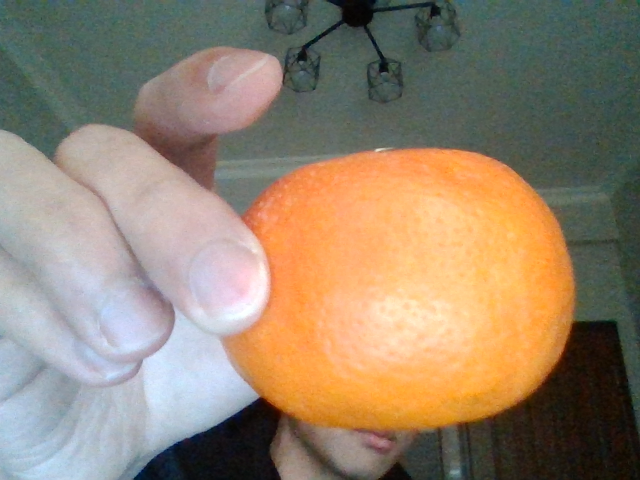

In [101]:
img_pil

In [108]:
show_class_id =  950
# show_class_id = None

In [109]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

In [110]:
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [111]:
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

In [112]:
draw = ImageDraw.Draw(result)


text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])

draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))

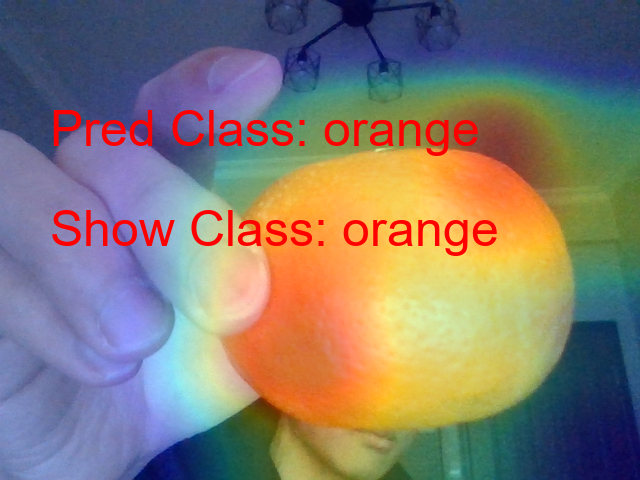

In [113]:
result

In [114]:
def process_frame(img, show_class_id=None, Chinese=True):
    
    img_bgr = img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_pil = Image.fromarray(img_rgb) 
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)
    pred_logits = model(input_tensor) 
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

    if show_class_id:
        show_id = show_class_id
    else:
        show_id = pred_id
        show_class_id = pred_id
        
    activation_map = cam_extractor(show_id, pred_logits)
    activation_map = activation_map[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)
    
    draw = ImageDraw.Draw(result)

    text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])

    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(result)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return img_bgr

In [115]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    # frame = process_frame(frame)
    frame = process_frame(frame, show_class_id=999)
    
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]:
        break

cap.release()

cv2.destroyAllWindows()